In [1]:
from tools import SuematsuData, kwarg_savefig, go, gprofiler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
data = SuematsuData()

In [3]:
model = PCA(random_state=0)
df_pca = pd.DataFrame(
    model.fit_transform(data.data), index=data.index, columns=[f"PC{i + 1}" for i in range(min(data.shape))]
)

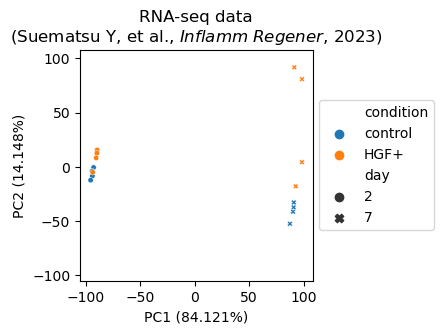

In [4]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(data=df_pca, x="PC1", y="PC2", style=data.meta.day, hue=data.meta.condition, ax=ax, s=15)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.set_xlim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
ax.set_ylim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
ax.legend(bbox_to_anchor=(1, .5), loc="center left")
ax.set_xlabel(f"PC1 ({(model.explained_variance_ratio_[0] * 100).round(3)}%)")
ax.set_ylabel(f"PC2 ({(model.explained_variance_ratio_[1] * 100).round(3)}%)")
ax.set(title="RNA-seq data\n(Suematsu Y, et al., $Inflamm\; Regener$, 2023)");

fig.savefig("../out/pca.png", **kwarg_savefig)

In [5]:
def component_viz(
    pca_model: PCA,
    data: pd.DataFrame,
    ax: plt.Axes = None,
    top: int = 30,
    dim_idx: int = 0,
    idx_starts_with: int = 1,
    color: str = None
) -> None:
    if ax is None:
        fig, ax = plt.subplots()
    comp = pd.DataFrame(
        model.components_[dim_idx],
        index=data.columns, 
        columns=["components"]
    ).sort_values("components", ascending=False)
    top = min(top, len(comp))
    sns.barplot(data=comp.iloc[:top, :], x=comp.index[:top], y=comp.components[:top], ax=ax, color=color)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(title=f"PC{dim_idx + idx_starts_with}")

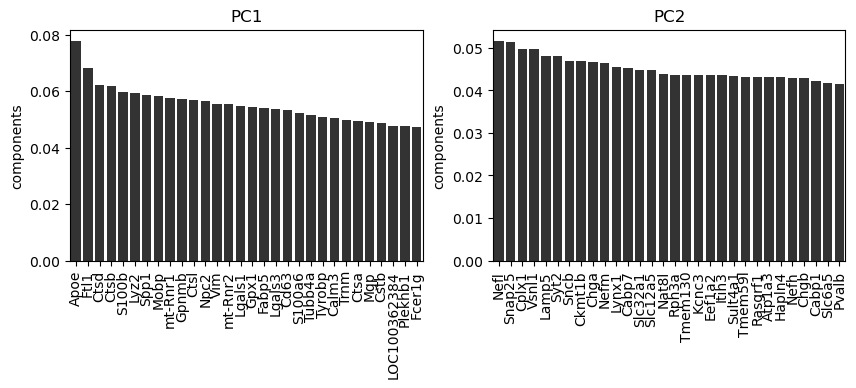

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
[component_viz(pca_model=model, data=data, ax=ax[i], dim_idx=i, color=".2") for i in range(2)];
fig.savefig("../out/components.png", **kwarg_savefig)

In [7]:
group = pd.Series(
    [f"day{day}-{condition}" for day, condition in zip(data.meta.day, data.meta.condition)],
    index=data.index
)

In [8]:
def cohens_d(data: pd.DataFrame, group: pd.Series, regex: str):
    df_group = data.groupby(group)
    n = df_group.count().filter(axis=0, regex=regex)
    s = df_group.std(ddof=0).filter(axis=0, regex=regex)
    xbar = df_group.mean().filter(axis=0, regex=regex)
    return xbar.iloc[::-1, :].diff().iloc[1, :] / np.sqrt((n * s).sum() / n.sum())

In [9]:
def gene_selection(data: pd.DataFrame, group: pd.Series, regex: str, d: float = .8, neg: bool = False):
    ret = cohens_d(data=data, group=group, regex=regex).dropna().sort_values(ascending=neg)
    return ret[ret > d] if not neg else ret[ret < -d]

In [10]:
def comp_by_d(
    pca_model: PCA,
    data: pd.DataFrame,
    group: pd.Series,
    regex: str,
    ax: plt.Axes = None,
    d: float = .8,
    dim_idx: int = 0,
    idx_starts_with: int = 1,
    palette: str = "coolwarm",
    s: float = 5,
    alpha: float = .1,
) -> None:
    if ax is None:
        fig, ax = plt.subplots()
    dat = pd.DataFrame(
        {
            "cohens_d": cohens_d(data, group, regex=regex).fillna(0),
            "components": model.components_[dim_idx]
        },
        index=data.columns
    )
    sns.scatterplot(data=dat, x="cohens_d", y="components", ax=ax, hue="cohens_d", palette=palette, s=s, legend=False, edgecolor=".2")
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    [ax.vlines(thresh, *ylim, linewidth=1, color=".2", label="$\pm$" + f"{d}" if thresh > 0 else None ) for thresh in [d, -d]]
    [
        ax.fill_between(
            np.linspace(thresh, lim, 1000), *ylim,
            alpha=alpha, zorder=0, color="b" if thresh < 0 else "r",
            label=f"{'up' if thresh > 0 else 'down'} ({(dat.cohens_d > d).sum() if thresh > 0 else (dat.cohens_d < -d).sum()})"
        ) for thresh, lim in zip(xlim, (-d, d))
    ]
    ax.set_xlim(*xlim), ax.set_ylim(*ylim)
    ax.set(
        ylabel=f"PC{dim_idx + idx_starts_with} components", 
        xlabel="Cohen's d",
        title=' vs '.join([v for v in data.groupby(group).count().filter(axis=0, regex=regex).index])
    )
    ax.legend()
    return ax

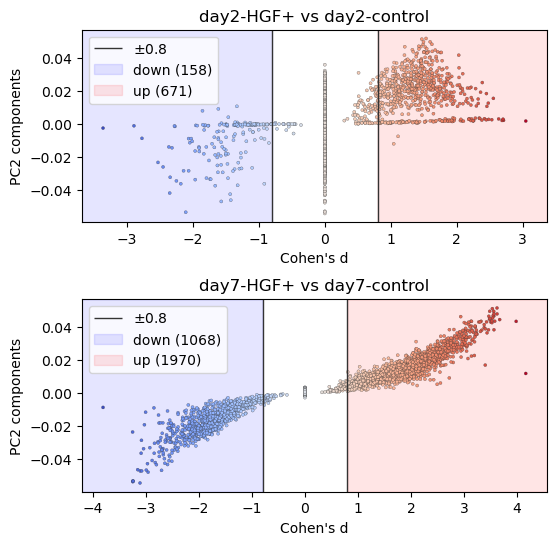

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=.4)
comp_by_d(pca_model=model, data=data.data, group=group, regex="day2", ax=ax[0], dim_idx=1)
comp_by_d(pca_model=model, data=data.data, group=group, regex="day7", ax=ax[1], dim_idx=1);

fig.savefig("../out/regulation_plot.png", **kwarg_savefig)

In [12]:
def gr_venn(
    data: pd.DataFrame,
    group: pd.Series,
    set_labels: tuple,
    ax: plt.Axes = None,
    d: float = .8,
    s: float = 5,
    alpha: float = .1,
    neg: bool = False,
    set_colors: tuple = ("C0", "C2", "C1")
) -> None:
    if ax is None:
        fig, ax = plt.subplots()
    a_genes = gene_selection(data, group, regex=set_labels[0], d=d, neg=neg).index
    b_genes = gene_selection(data, group, regex=set_labels[1], d=d, neg=neg).index
    n_intersection = len([v for v in a_genes if v in b_genes])
    v = venn2(
        subsets=(len(a_genes) - n_intersection, len(b_genes) - n_intersection, n_intersection),
        set_labels = set_labels,
        ax=ax
    )
    [v.get_patch_by_id(p).set_color(c) for p, c in zip(["10", "01", "11"], set_colors)]
    ax.set(title=f"{'down' if neg else 'up'}regulated genes")
    return ax

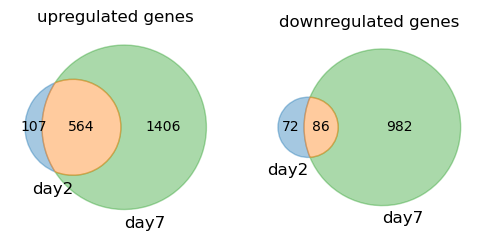

In [13]:
from matplotlib_venn import venn2

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

gr_venn(data=data.data, group=group, set_labels=("day2", "day7"), ax=ax[0])
gr_venn(data=data.data, group=group, set_labels=("day2", "day7"), ax=ax[1], neg=True);

fig.savefig("../out/venn.png", **kwarg_savefig)

In [14]:
d = .8

In [15]:
a_genes = gene_selection(data.data, group, regex="day2", d=d)
b_genes = gene_selection(data.data, group, regex="day7", d=d)

In [16]:
aonly = a_genes.loc[[v for v in a_genes.index if v not in b_genes.index]]
bonly = b_genes.loc[[v for v in b_genes.index if v not in a_genes.index]]
common = a_genes.loc[[v for v in a_genes.index if v in b_genes.index]]

go_up = go(pd.concat([aonly, bonly, common]))

go_up

In [71]:
def go_barplot(
    data: pd.DataFrame,
    ax: plt.Axes = None,
    top: int = None,
    grid: bool = True,
    palette: str = None
):
    top = min(len(data), top) if isinstance(top, int) else len(data)
    if ax is None:
        ysize = (lambda x: max(5, int(x / 5)))(top)
        _, ax = plt.subplots(figsize=(5, ysize))
    
    res = gprofiler(data).iloc[:top, :].iloc[::-1, :]
    res = pd.DataFrame({
        "term_name": res.term_name,
        "$-\log_{10}Pval.$": -np.log10(res.p_value),
        "Intersection size" :res.intersection_size,
        "gene_ratio": res.intersection_size / res.term_size
    })

    sns.scatterplot(
        data=res, 
        x="gene_ratio", 
        y="term_name", 
        size="Intersection size", 
        hue="$-\log_{10}Pval.$", 
        palette=palette,
        **{"edgecolor": ".2", "linewidth":.5}
    )

    ax.set_ylim(-.5, top + .5)
    ax.set(ylabel="", xlabel="Gene Ratio")
    ax.legend(loc="center left", bbox_to_anchor=(1, .5))
    
    return ax

fig, ax = plt.subplots()
go_barplot(pd.concat([aonly, bonly, common]), ax=ax, top=30, palette="viridis")

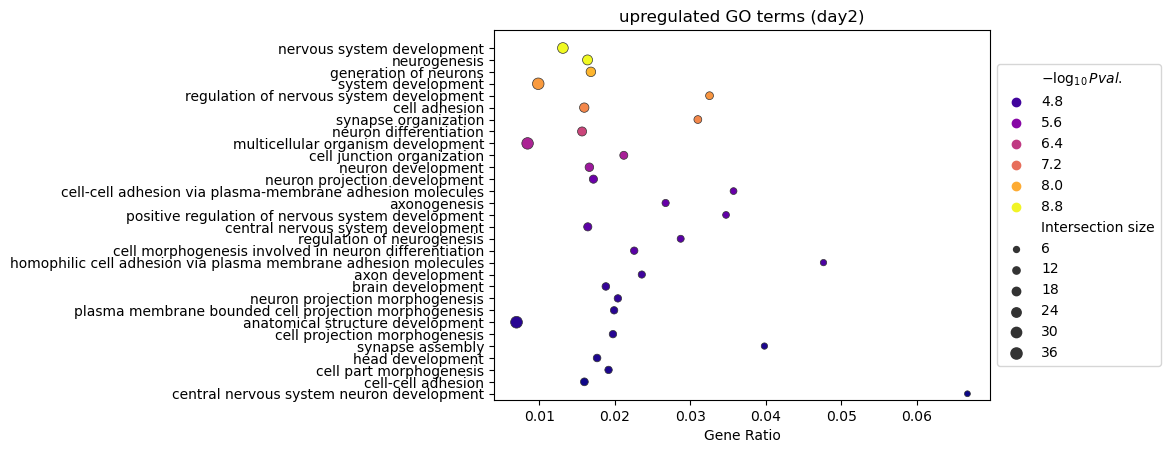

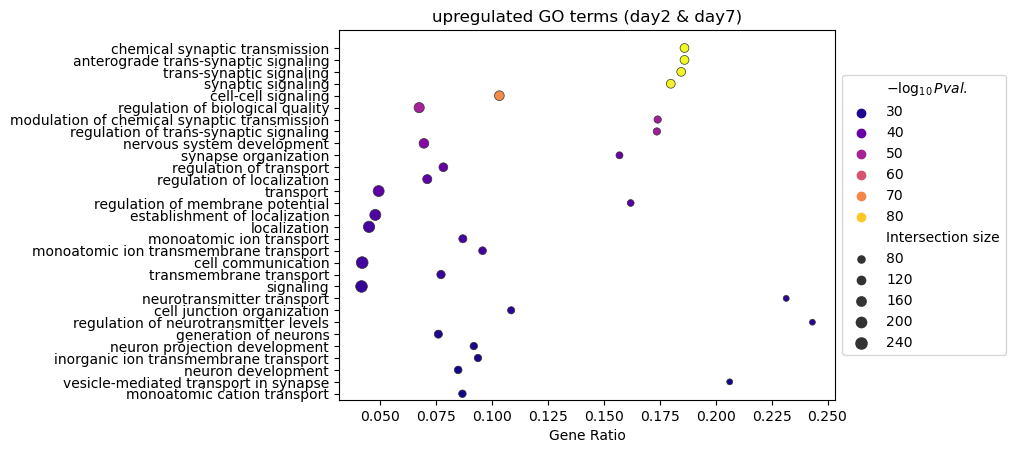

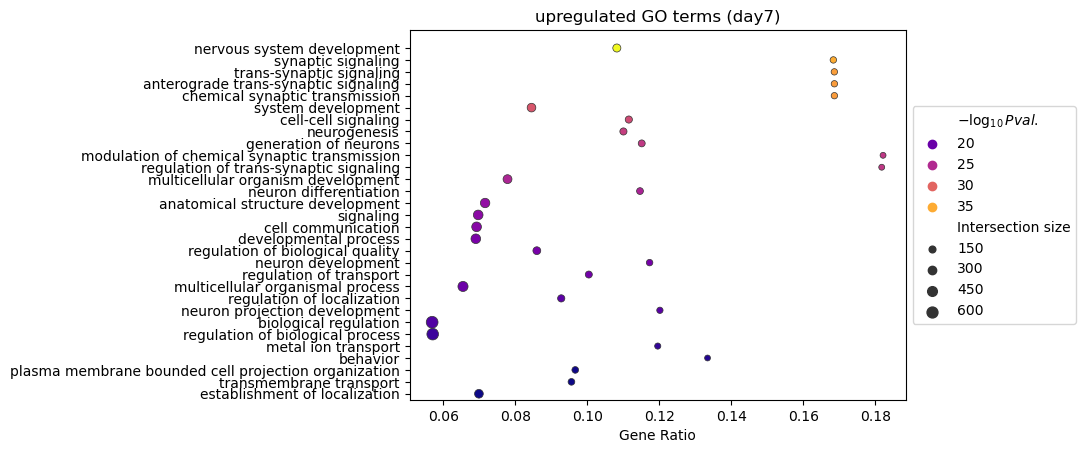

In [93]:
for d, name in zip([aonly, common, bonly], ["day2", "day2 & day7", "day7"]):
    fig, ax = plt.subplots()
    go_barplot(d, ax=ax, top=30, palette="plasma")
    ax.set_title(f"upregulated GO terms ({name})")
    fig.savefig(f"../out/go_up_{name.replace(' & ', '+')}.png", **kwarg_savefig)

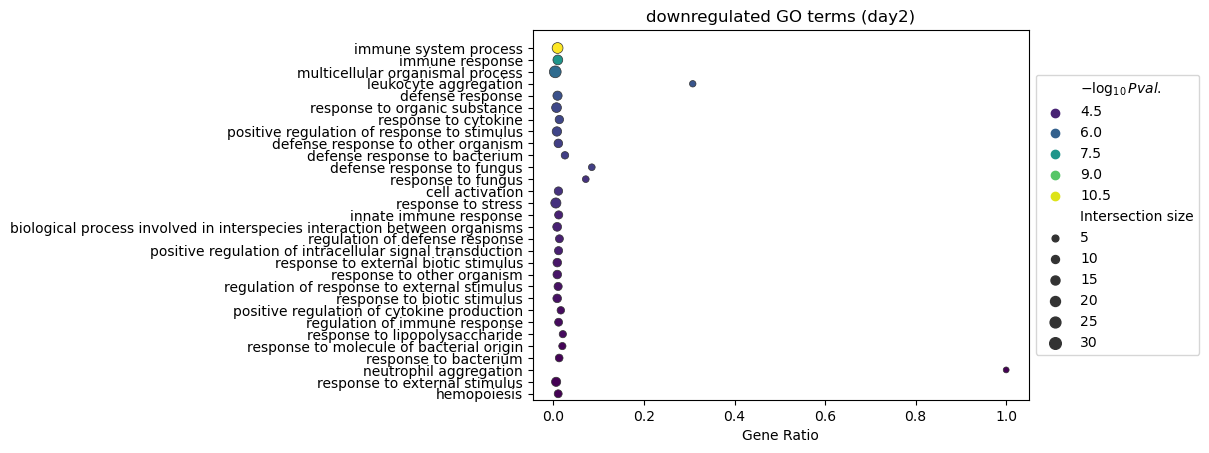

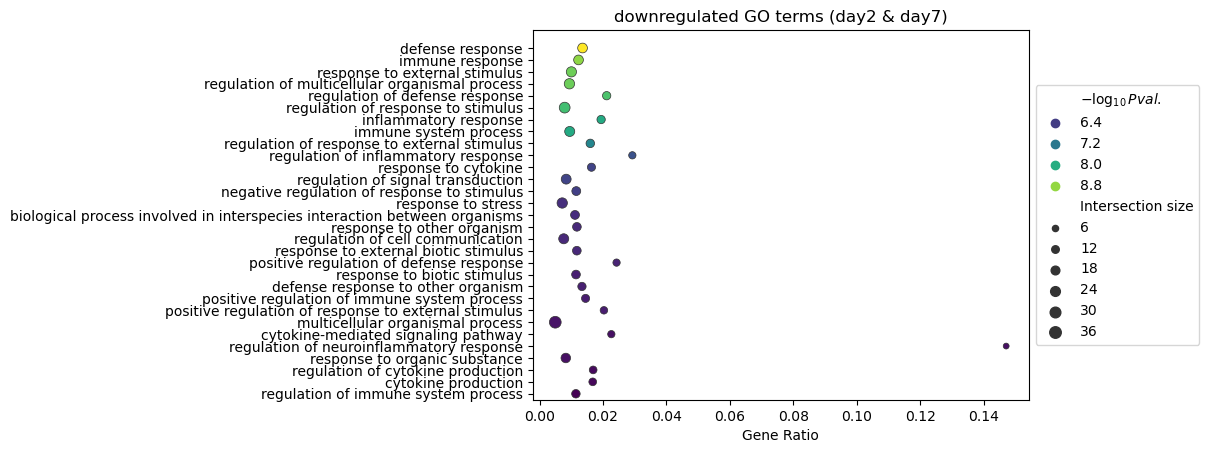

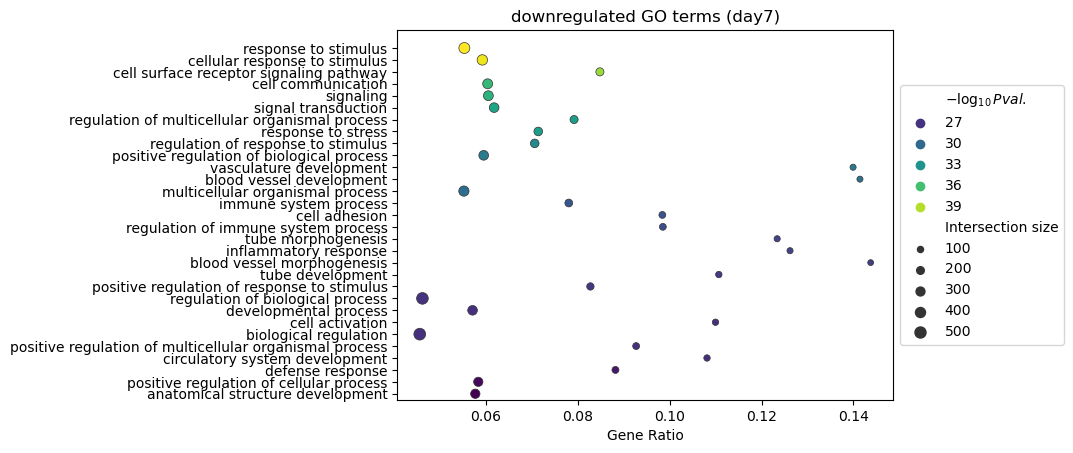

In [94]:
for d, name in zip([aonly2, common2, bonly2], ["day2", "day2 & day7", "day7"]):
    fig, ax = plt.subplots()
    go_barplot(d, ax=ax, top=30, palette="viridis")
    ax.set_title(f"downregulated GO terms ({name})")
    fig.savefig(f"../out/go_down_{name.replace(' & ', '+')}.png", **kwarg_savefig)